In [ ]:
## Run this cell to install required packages
# !uv pip install pydriller pandas matplotlib tqdm -q

In [ ]:
import csv
from pydriller import Repository, Git
import os
import subprocess
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
REPO_URLS = [
    "https://github.com/psf/requests.git",
    "https://github.com/pallets/flask.git",
    "https://github.com/scikit-learn/scikit-learn.git",
    # "https://github.com/ShardulJunagade/miniTorch.git"
]
NUM_REPOS = len(REPO_URLS)
REPO_FOLDER = "repos"
os.makedirs(REPO_FOLDER, exist_ok=True)

OUTPUT_FOLDER = "results"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_CSV = "diff_analysis.csv"
OUTPUT_CSV_PATH = os.path.join(OUTPUT_FOLDER, OUTPUT_CSV)

In [ ]:
# clone the repositories if not already cloned
for url in REPO_URLS:
    repo_name = url.split("/")[-1].replace(".git", "")
    repo_path = os.path.join(REPO_FOLDER, repo_name)
    if not os.path.exists(repo_path):
        print(f"🔄 Cloning {url}...")
        subprocess.run(["git", "clone", url, repo_path])
    else:
        print(f"📦 Repository {repo_name} already exists. Skipping clone.")

📦 Repository requests already exists. Skipping clone.
📦 Repository flask already exists. Skipping clone.
📦 Repository scikit-learn already exists. Skipping clone.


In [ ]:
def extract_diffs_from_repo(repo_url):
    repo_name = repo_url.split('/')[-1].replace('.git', '')
    repo_path = os.path.join(REPO_FOLDER, repo_name)

    # Use the Git object for direct command execution
    git_repo = Git(repo_path)
    rows = []

    commits_list = list(Repository(repo_path).traverse_commits())
    for commit in tqdm(commits_list, desc=f"Traversing commits in {repo_name}"):
        if not commit.parents:
            continue
        parent_commit_sha = commit.parents[0]

        for modified_file in commit.modified_files:
            # Process only file modifications, not new files or deletions
            if modified_file.old_path and modified_file.new_path:
                # Define the common flags required by the assignment 
                # -w ignores whitespace
                # --ignore-blank-lines ignores differences in blank lines
                common_flags = [
                    '-w',
                    '--ignore-blank-lines',
                    parent_commit_sha,
                    commit.hash,
                    '--',
                    modified_file.new_path
                ]

                # 1. Myers Diff (standard git diff)
                diff_myers_output = git_repo.repo.git.diff(*common_flags)
                # 2. Histogram Diff
                diff_hist_output = git_repo.repo.git.diff('--histogram', *common_flags)
                # Compare Diff Outputs
                discrepancy = "Yes" if diff_myers_output != diff_hist_output else "No"

                rows.append({
                    "old_file_path": modified_file.old_path,
                    "new_file_path": modified_file.new_path,
                    "commit_sha": commit.hash,
                    "parent_commit_sha": parent_commit_sha,
                    "commit_message": commit.msg.strip(),
                    "diff_myers": diff_myers_output,
                    "diff_hist": diff_hist_output,
                    "Discrepancy": discrepancy
                })
    return rows

In [ ]:
fieldnames = [
    "old_file_path", "new_file_path", "commit_sha", "parent_commit_sha",
    "commit_message", "diff_myers", "diff_hist", "Discrepancy"
]

all_data = []

for i, repo_url in enumerate(REPO_URLS, start=1):
    repo_name = repo_url.split('/')[-1].replace('.git', '')
    print(f"\n--- Repository {i}/{NUM_REPOS} : {repo_name} ---")
    rows = extract_diffs_from_repo(repo_url)
    print(f"📊 Collected {len(rows)} records from this repository")
    all_data.extend(rows)

    with open(os.path.join(OUTPUT_FOLDER, f"{repo_name}_{OUTPUT_CSV}"), mode='w', newline='', encoding='utf-8', errors='surrogateescape') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)
    print(f"💾 Data from {repo_name} written to {OUTPUT_FOLDER}/{repo_name}_{OUTPUT_CSV}")

with open(OUTPUT_CSV_PATH, mode='w', newline='', encoding='utf-8', errors='surrogateescape') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_data)

print(f"\n✅ Analysis complete. Data saved to {OUTPUT_CSV_PATH}.")


--- Repository 1/3 : requests ---


Traversing commits in requests: 100%|██████████| 6373/6373 [33:48<00:00,  3.14it/s]  


📊 Collected 7019 records from this repository
💾 Data from requests written to results/requests_diff_analysis.csv

--- Repository 2/3 : flask ---


Traversing commits in flask: 100%|██████████| 5463/5463 [33:14<00:00,  2.74it/s]   


📊 Collected 8380 records from this repository
💾 Data from flask written to results/flask_diff_analysis.csv

--- Repository 3/3 : scikit-learn ---


Traversing commits in scikit-learn: 100%|██████████| 32801/32801 [7:16:53<00:00,  1.25it/s]       


📊 Collected 80107 records from this repository
💾 Data from scikit-learn written to results/scikit-learn_diff_analysis.csv

🎉 Analysis complete. Data saved to results\diff_analysis.csv.


In [ ]:
# Load the DataFrame
df = pd.read_csv("results/diff_analysis.csv", encoding='utf-8', encoding_errors='surrogateescape')
display(df)

,old_file_path,new_file_path,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_hist,Discrepancy
0,README,README,d0bf5538097cbdee663eddf4e29e9f34106c67cb,e7615cbc6b4af5985c4e0d4848a426e2d35f79c3,no mo of that,diff --git a/README b/README\ndeleted file mod...,diff --git a/README b/README\ndeleted file mod...,No
1,HISTORY.rst,HISTORY.rst,72e99c0f49823a5b798f8d15896480b7216c4fba,c51b44d96bb460ebea3daee7deeff6b686585087,histories,diff --git a/HISTORY.rst b/HISTORY.rst\nnew fi...,diff --git a/HISTORY.rst b/HISTORY.rst\nnew fi...,No
2,reqs.txt,reqs.txt,853a4fd04ce3f4644e204418ee2cd694d9f29180,ffdbc387ea67398ac123b2ff5a5d69df3e198340,generic skeleton,diff --git a/reqs.txt b/reqs.txt\nnew file mod...,diff --git a/reqs.txt b/reqs.txt\nnew file mod...,No
3,README.rst,README.rst,45c6897128c1e20a98cf259101067123a4768793,a6ffd97ef150f50eb1a0e0e54edf217831011753,good readme update,diff --git a/README.rst b/README.rst\nindex df...,diff --git a/README.rst b/README.rst\nindex df...,Yes
4,README.rst,README.rst,23842865e973f9aacd58fa935f1fec5c2069de11,45c6897128c1e20a98cf259101067123a4768793,readme update,diff --git a/README.rst b/README.rst\nindex 05...,diff --git a/README.rst b/README.rst\nindex 05...,No
...,...,...,...,...,...,...,...,...
95501,sklearn\conftest.py,sklearn\conftest.py,ad04078a22edff875e478e7f67f1a3bd60bc086e,4976c1291448cd5ab7ba3f97dab4814321be7845,MNT Avoid pytest warnings when pytest-run-para...,diff --git a/sklearn/conftest.py b/sklearn/con...,diff --git a/sklearn/conftest.py b/sklearn/con...,No
95502,doc\developers\develop.rst,doc\developers\develop.rst,be9dd4d4c1f03b8d27311f2d43fcb3c88bdea55c,ad04078a22edff875e478e7f67f1a3bd60bc086e,DOC Fix dataclass imports in tags example (#32...,diff --git a/doc/developers/develop.rst b/doc/...,diff --git a/doc/developers/develop.rst b/doc/...,No
95503,.github\workflows\emscripten.yml,.github\workflows\emscripten.yml,69fd8e53f61395e3d8b4a7cefeb25351d8301050,be9dd4d4c1f03b8d27311f2d43fcb3c88bdea55c,MNT Skip test relying on `np.seterr` for Pyodi...,diff --git a/.github/workflows/emscripten.yml ...,diff --git a/.github/workflows/emscripten.yml ...,No
95504,sklearn\preprocessing\tests\test_data.py,sklearn\preprocessing\tests\test_data.py,69fd8e53f61395e3d8b4a7cefeb25351d8301050,be9dd4d4c1f03b8d27311f2d43fcb3c88bdea55c,MNT Skip test relying on `np.seterr` for Pyodi...,diff --git a/sklearn/preprocessing/tests/test_...,diff --git a/sklearn/preprocessing/tests/test_...,No


Discrepancy Counts:
Discrepancy
No     91508
Yes     3998
Name: count, dtype: int64


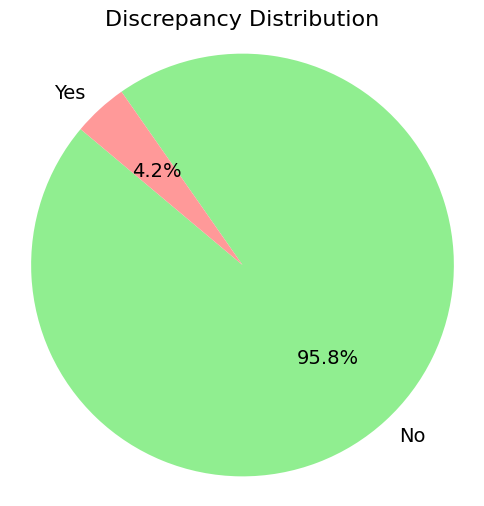

In [3]:
discrepancy_counts = df['Discrepancy'].value_counts()
print("Discrepancy Counts:")
print(discrepancy_counts)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
colors = ['lightgreen', '#ff9999']  # Custom color palette
wedges, texts, autotexts = plt.pie(
    discrepancy_counts,
    labels=discrepancy_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 14}
)
plt.title('Discrepancy Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('results/mismatch_analysis_pie_chart.png')
plt.show()